In [3]:
install.packages("tidyquant")

also installing the dependencies ‘fastmap’, ‘tzdb’, ‘timechange’, ‘globals’, ‘htmltools’, ‘listenv’, ‘parallelly’, ‘clock’, ‘generics’, ‘hardhat’, ‘ipred’, ‘lubridate’, ‘furrr’, ‘htmlwidgets’, ‘crosstalk’, ‘warp’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘future’, ‘quadprog’, ‘cli’, ‘glue’, ‘lifecycle’, ‘pillar’, ‘rlang’, ‘tibble’, ‘tidyselect’, ‘vctrs’, ‘purrr’, ‘stringr’, ‘cpp11’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘stringi’, ‘slider’, ‘anytime’, ‘forecast’, ‘tsfeatures’, ‘PerformanceAnalytics’, ‘dplyr’, ‘Quandl’, ‘riingo’, ‘alphavantager’, ‘tidyr’, ‘timetk’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
# rm(list = ls())
setwd("/mnt/c/git_repos/iORD_hepatitis/")
require(tidyverse)
require(data.table)
require(lubridate)
require(foreach)
require(randomcoloR)
require(tidyquant)
require(ggpubr)

Loading required package: tidyverse
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: lubridate

Attaching package: ‘lubridate’

The following objects are masked from ‘

### Load data

In [2]:
age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15")) %>%
    arrange(AttendanceStartDate) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))


micro_df <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceMonth = as.Date(AttendanceMonth),
           AttendanceTwoMonth = as.Date(AttendanceTwoMonth)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01")) %>%
    rename(MicroTestName = TestName) %>%
    # Parse records
    mutate(BugName = ifelse(BatTestCode == "QADN" & ResultFull == "DETECTED", "Adenovirus", BugName)) %>%
    mutate(BugName = ifelse(grepl("Adenovirus", BugName, ignore.case = T), "Adenovirus", BugName))

test_df <- fread("data/IORD_ASHep-UE_34_20230120_LIMS.csv") %>%
    mutate(CollectionDateTime = as.Date(CollectionDateTime),
           AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    filter(AttendanceStartDate < as.Date("2023-01-01"))

Joining with `by = join_by(ClusterID, AttendanceStartDate)`
Warning message in left_join(., age_df):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 93 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning.”


In [1]:
fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(AttendanceMonth = cut(AttendanceStartDate, breaks = "month"),
           AttendanceTwoMonth = cut(AttendanceStartDate, breaks = "2 months")) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "month")) %>%
    summarise(min(age_upon_presentation))

ERROR: Error in fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>% mutate(AttendanceStartDate = as.Date(AttendanceStartDate), : could not find function "%>%"


In [53]:
table(age_df$LocationAttended)


       H-WD EAU   H-WD Rowan AU   J-DC Resp DDU            J-ED       J-WD 4AAU 
          13484           15076             763          746361            1360 
    J-WD 5B AAU        J-WD EAU J-WD JR_Chi CDU     J-WD L4 AAU  J-WD SEU Ambul 
          23180           45325            9269           31549               8 
     J-WD SEU D      J-WD SEU E      J-WD SEU F J-WD SEU Triage 
            172             166             133           35387 

In [48]:
age_df %>%
    summarise(min(age_upon_presentation))

min(age_upon_presentation)
<dbl>
1


In [46]:
unique(micro_df$LocationAttended)

[1] "J-ED"            "J-WD L4 AAU"     "J-WD SEU Triage" "J-WD JR_Chi CDU"
 [5] "H-WD EAU"        "J-WD EAU"        "H-WD Rowan AU"   "J-WD 4AAU"      
 [9] "J-WD 5B AAU"     "J-DC Resp DDU"   "J-WD SEU D"      "J-WD SEU E"     
[13] "J-WD SEU F"      "J-WD SEU Ambul"

In [43]:
fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
select(SpecimenCollectionLocation)

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `SpecimenCollectionLocation` doesn't exist.


In [27]:
micro_df %>%
    filter(BatTestCode %in% adeno_tests$BatTestCode) %>%
    distinct(AttendanceStartDate, ClusterID, .keep_all = T) %>%
    distinct(SpecimenCode, SpecimenFull)

SpecimenCode,SpecimenFull
<chr>,<chr>
SW,SWAB;blister on thumb
NS,NOSE SWAB
TS,THROAT SWAB
TS,THROAT SWABTHROAT SWAB
NTS,NOSE & THROAT SWAB
SW,SWABTHROAT SWAB
VESS,VESICLE SWAB
TS,THROAT SWABMOUTH SWAB
NPA,NASO PHARYNGEAL ASPIRATE


In [37]:
16/179

[1] 0.08938547

In [41]:
121 / 3707

[1] 0.03264095

In [42]:
micro_df$Sp

[1] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
    [5] "J-ED"            "J-WD L4 AAU"     "J-WD SEU Triage" "J-WD SEU Triage"
    [9] "J-WD SEU Triage" "J-ED"            "J-ED"            "J-ED"           
   [13] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [17] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [21] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [25] "J-ED"            "J-WD L4 AAU"     "J-WD L4 AAU"     "J-WD L4 AAU"    
   [29] "J-WD JR_Chi CDU" "J-ED"            "J-ED"            "J-ED"           
   [33] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [37] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [41] "J-ED"            "J-ED"            "H-WD EAU"        "H-WD EAU"       
   [45] "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage" "J-ED"           
   [49] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [53] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [57] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [61] "J-ED"            "J-ED"            "H-WD EAU"        "J-ED"           
   [65] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [69] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [73] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [77] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [81] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [85] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [89] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [93] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
   [97] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [101] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [105] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [109] "J-ED"            "J-WD EAU"        "J-WD EAU"        "J-WD EAU"       
  [113] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [117] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [121] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [125] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [129] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [133] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [137] "H-WD EAU"        "H-WD EAU"        "J-ED"            "J-ED"           
  [141] "H-WD EAU"        "J-ED"            "H-WD EAU"        "J-ED"           
  [145] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [149] "J-ED"            "J-ED"            "H-WD Rowan AU"   "H-WD Rowan AU"  
  [153] "H-WD Rowan AU"   "H-WD Rowan AU"   "H-WD Rowan AU"   "H-WD Rowan AU"  
  [157] "J-ED"            "J-ED"            "H-WD EAU"        "H-WD EAU"       
  [161] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [165] "J-ED"            "H-WD Rowan AU"   "H-WD EAU"        "H-WD EAU"       
  [169] "H-WD EAU"        "H-WD Rowan AU"   "H-WD Rowan AU"   "J-ED"           
  [173] "J-ED"            "J-ED"            "J-ED"            "J-ED"           
  [177] "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage"
  [181] "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage"
  [185] "J-WD SEU Triage" "J-WD SEU Triage" "J-ED"            "J-ED"           
  [189] "J-ED"            "H-WD EAU"        "H-WD EAU"        "J-ED"           
  [193] "J-ED"            "J-ED"            "J-ED"            "J-WD SEU Triage"
  [197] "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage" "J-WD SEU Triage"
  [2

In [38]:
adeno_tests <- micro_df %>%
    filter(grepl("adeno", BugName, ignore.case = T)) %>%
    distinct(BatTestCode)

micro_df %>% 
    filter(BatTestCode %in% adeno_tests$BatTestCode) %>%
    distinct(AttendanceStartDate, ClusterID, .keep_all = T) %>%
    mutate(is_eye = ifelse(grepl("EYE", SpecimenCode)| grepl("cornea|eye", SpecimenFull, ignore.case = T),
                           T, F)) %>%
    group_by(is_eye) %>%
    summarise(n = n())
#     group_by(SpecimenCode) %>%
#     summarise(n = n())

is_eye,n
<lgl>,<int>
FALSE,3586
TRUE,121


In [16]:
micro_df %>% 
    distinct(ClusterID, AttendanceStartDate, BugName, .keep_all = T) %>%
    select(ClusterID, AttendanceStartDate, SpecimenCode, SpecimenFull, 
           BatTestCode, BatTestName, TestCode, 
           MicroTestName, Result, ResultFull,
           BugName) %>%
    filter(BugName == "Adenovirus") %>%
#     filter(SpecimenCode == "EYE") %>%
    group_by(SpecimenCode, SpecimenFull, BatTestName) %>%
    summarise(n = n()) %>%
    ungroup() %>%
    summarise(sum(n))
13/179*100

`summarise()` has grouped output by 'SpecimenCode', 'SpecimenFull'. You can override using the `.groups` argument.


sum(n)
<int>
179


[1] 7.26257

In [46]:
age_filt <- age_df %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    mutate(AttendanceMonth = as.Date(AttendanceMonth)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")))

nrow(age_filt)

[1] 903433

`summarise()` has grouped output by 'ClusterID', 'AttendanceStartDate'. You can override using the `.groups` argument.
Joining with `by = join_by(ClusterID, AttendanceStartDate, AttendanceMonth)`
`summarise()` has grouped output by 'AttendanceMonth'. You can override using the `.groups` argument.


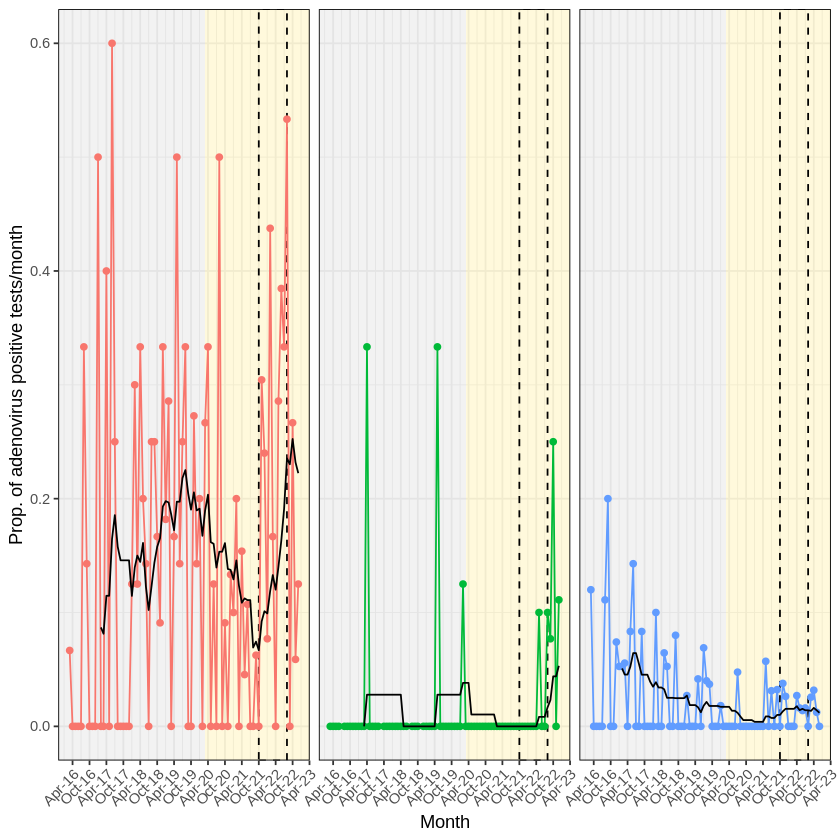

In [67]:
adeno_tests <- micro_df %>%
    filter(grepl("adeno", BugName, ignore.case = T)) %>%
    distinct(BatTestCode)
adeno_tests <- c("QADN", adeno_tests$BatTestCode)

micro_filt <- micro_df %>%
    filter(BatTestCode %in% adeno_tests) %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F))

# Code multiple tests
multi_filt <- micro_filt %>%
    group_by(ClusterID, AttendanceStartDate, AttendanceMonth) %>%
    summarise(n_pos = sum(adeno_pos)) %>%
    mutate(adeno_pos = ifelse(n_pos > 0, T, F))

micro_plot_df <- multi_filt %>%
    inner_join(age_filt) %>%
    group_by(AttendanceMonth, age_group) %>%
    summarise(pos_rate = sum(adeno_pos) / n_distinct(ClusterID, AttendanceStartDate),
              n_tests = n_distinct(ClusterID, AttendanceStartDate)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15")))

# micro_plot_df <- all_months_df %>%
#     left_join(micro_plot_df) %>%
#     mutate(pos_rate = ifelse(is.na(pos_rate), 0, pos_rate),
#            n_tests = ifelse(is.na(n_tests), 0, n_tests))

plt1 <- micro_plot_df %>%
    ggplot(aes(x = AttendanceMonth, y = pos_rate, color = age_group)) +
        annotate("rect",
         xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
         ymin = -Inf, ymax = Inf,
         fill = "grey83",
         alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        geom_line() +
        geom_point() +
        geom_ma(ma_fun = SMA, n = 12, color = "black", lty = 1) +
        theme_bw() +
        labs(x = "Month", y = "Prop. of adenovirus positive tests/month",
              color = "Age group") +
        facet_grid(cols = vars(age_group), 
                   scales = "free") +
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 month") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),
              panel.border = element_rect(color = "black", fill = NA),
              legend.position = "none",
              strip.background = element_blank(),
              strip.text = element_blank())
plt1
# ggsave("results/prop_pos_tests.pdf", dpi = 600, width = 20, height = 3)

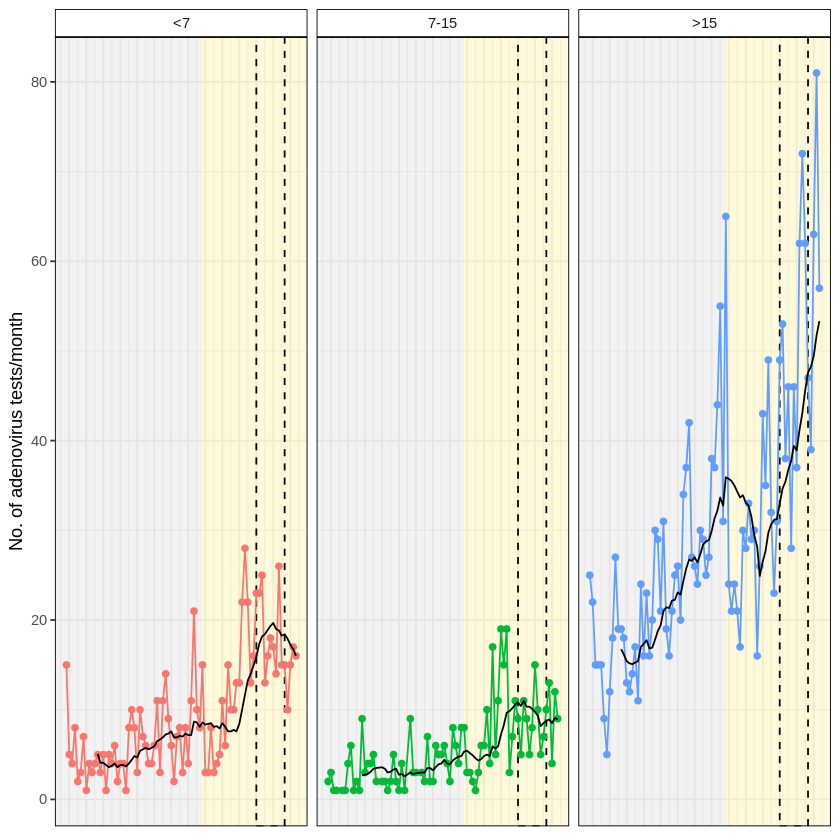

In [68]:
plt2 <- micro_plot_df %>%
    ggplot(aes(AttendanceMonth, n_tests, color = age_group)) +
        annotate("rect",
         xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
         ymin = -Inf, ymax = Inf,
         fill = "grey83",
         alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-08-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        geom_point() +
        geom_line() +
        geom_ma(ma_fun = SMA, n = 12, color = "black", lty = 1) +
        labs(x = "Month", y = "No. of adenovirus tests/month",
              color = "Age group") +
        facet_grid(cols = vars(age_group), 
                   scales = "free") +
        scale_x_date(date_labels="%b-%y", date_breaks  = "6 month") +
        theme_bw() +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              axis.title.x = element_blank(),
              legend.position = "none",
              strip.background = element_rect(fill = "white", color = "black"),
              panel.border = element_rect(color = "black", fill = NA))
plt2
# ggsave("results/n_adeno_tests.big.pdf", plot = plt2, dpi = 600, width = 25, height = 3)

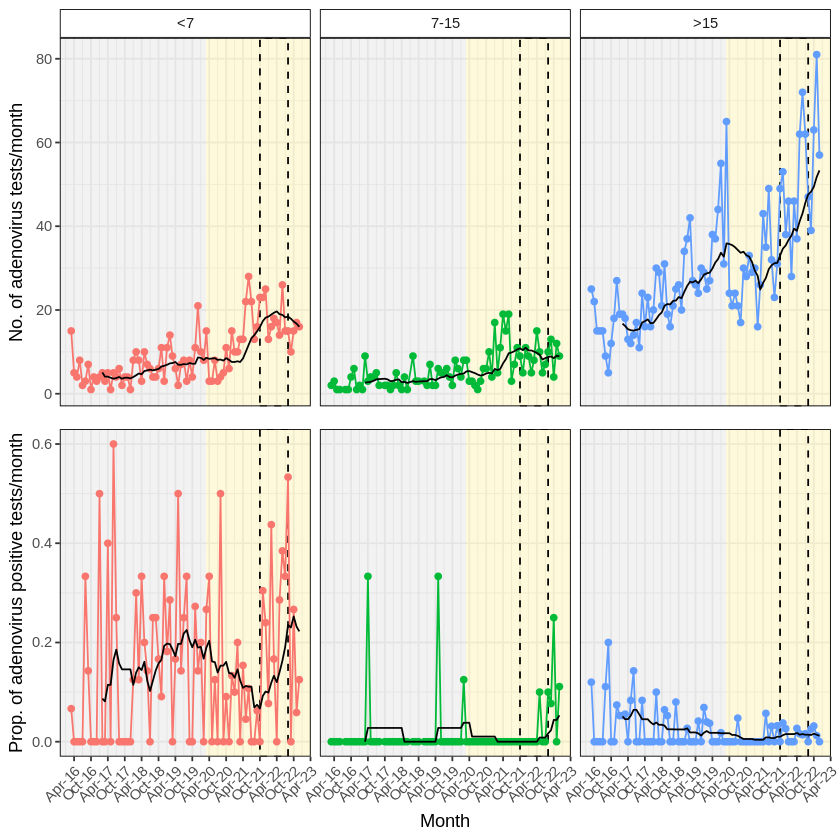

In [69]:
ggpubr::ggarrange(plt2, plt1, nrow = 2, align = "v")

ggsave("results/multi_adeno_tests.pdf", dpi = 600, width = 12, height = 8)
# ggsave("results/multi_adeno_tests.big.pdf", dpi = 600, width = 12, height = 8)

### Adeno-positive tests within and outside AS-Hep-UA outbreak

In [72]:
adeno_df <- micro_filt %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F)) %>%
    group_by(ClusterID, AttendanceStartDate) %>%
    summarise(n_adeno = sum(adeno_pos)) %>%
    mutate(adeno_pos = ifelse(n_adeno > 0, T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    left_join(age_filt %>% select(ClusterID, AttendanceStartDate, age_group)) %>%
    ungroup()

nrow(adeno_df)
head(adeno_df)


`summarise()` has grouped output by 'ClusterID'. You can override using the `.groups` argument.
Joining with `by = join_by(ClusterID, AttendanceStartDate)`


[1] 3707

ClusterID,AttendanceStartDate,n_adeno,adeno_pos,is_outbreak,age_group
<int>,<date>,<int>,<lgl>,<lgl>,<fct>
354,2022-09-07,0,FALSE,FALSE,7-15
589,2022-03-21,0,FALSE,TRUE,>15
2855,2018-12-20,0,FALSE,FALSE,>15
3763,2016-04-12,0,FALSE,FALSE,>15
4199,2021-12-27,0,FALSE,TRUE,<7
4583,2019-04-05,0,FALSE,FALSE,>15


In [126]:
adeno_df %>%
    group_by(age_group) %>%
    summarise(n_pos = sum(adeno_pos),
              total = n_distinct(ClusterID, AttendanceStartDate)) %>%
    mutate(prop_pos = round(n_pos / total * 100, 1))

count_df <- adeno_df %>%
    mutate(epoch = case_when(AttendanceStartDate >= as.Date("2016-03-01") & AttendanceStartDate <= as.Date("2020-03-10") ~ "pre-COVID",
                             AttendanceStartDate >= as.Date("2016-03-11") & AttendanceStartDate <= as.Date("2022-12-31") ~ "COVID")) %>%
    group_by(epoch) %>%
    summarise(n_pos_epoch = sum(adeno_pos))

adeno_df %>%
    mutate(epoch = case_when(AttendanceStartDate >= as.Date("2016-03-01") & AttendanceStartDate <= as.Date("2020-03-10") ~ "pre-COVID",
                             AttendanceStartDate >= as.Date("2016-03-11") & AttendanceStartDate <= as.Date("2022-12-31") ~ "COVID")) %>%
    group_by(epoch, age_group) %>%
    summarise(n_pos = sum(adeno_pos),
              total = n_distinct(ClusterID, AttendanceStartDate)) %>%
    left_join(count_df) %>%
    mutate(prop_pos = round(n_pos / n_pos_epoch * 100, 1))

adeno_df %>%
    filter(is_outbreak) %>%
    group_by(age_group) %>%
    summarise(n_pos = sum(adeno_pos),
              total = n()) %>%
    mutate(prop_pos = round(n_pos / sum(n_pos) * 100, 1),
           total = sum(n_pos))

age_group,n_pos,total,prop_pos
<fct>,<int>,<int>,<dbl>
<7,124,781,15.9
7-15,9,440,2.0
>15,46,2486,1.9


`summarise()` has grouped output by 'epoch'. You can override using the `.groups` argument.
Joining with `by = join_by(epoch)`


epoch,age_group,n_pos,total,n_pos_epoch,prop_pos
<chr>,<fct>,<int>,<int>,<int>,<dbl>
COVID,<7,79,478,100,79.0
COVID,7-15,5,281,100,5.0
COVID,>15,16,1335,100,16.0
pre-COVID,<7,45,303,79,57.0
pre-COVID,7-15,4,159,79,5.1
pre-COVID,>15,30,1151,79,38.0


age_group,n_pos,total,prop_pos
<fct>,<int>,<int>,<dbl>
<7,51,60,85.0
7-15,2,60,3.3
>15,7,60,11.7


In [1]:
adeno_df

ERROR: Error in eval(expr, envir, enclos): object 'adeno_df' not found


In [127]:
adeno_df %>%
    group_by(is_outbreak) %>%
    summarise(n = n(),
              n_pos = sum(adeno_pos),
              prop_pos = sum(adeno_pos) / n())

adeno_df %>%
    group_by(age_group) %>%
    summarise(n = n(),
              n_pos = sum(adeno_pos),
              prop_pos = sum(adeno_pos) / n())

cont_table <- adeno_df %>%
    group_by(is_outbreak, adeno_pos) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate)) %>%
    pivot_wider(id_cols = is_outbreak, names_from = "adeno_pos", values_from = "n") %>%
    column_to_rownames("is_outbreak")
cont_table
fisher.test(cont_table)



is_outbreak,n,n_pos,prop_pos
<lgl>,<int>,<int>,<dbl>
FALSE,2868,119,0.04149233
TRUE,839,60,0.07151371


age_group,n,n_pos,prop_pos
<fct>,<int>,<int>,<dbl>
<7,781,124,0.15877081
7-15,440,9,0.02045455
>15,2486,46,0.01850362


`summarise()` has grouped output by 'is_outbreak'. You can override using the `.groups` argument.


,FALSE,TRUE
,<int>,<int>
FALSE,2749,119
TRUE,779,60



	Fisher's Exact Test for Count Data

data:  cont_table
p-value = 0.0006542
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.268650 2.473262
sample estimates:
odds ratio 
  1.778926 


### Adeno tests within and outside outbreak

In [128]:
micro_all_df <- micro_df %>%
    distinct(ClusterID, AttendanceStartDate, BatTestCode, .keep_all = T) %>%
    mutate(is_adeno_test = ifelse(BatTestCode %in% adeno_tests, T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    mutate(age_group = factor(age_group, c("<7", "7-15", ">15"))) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

micro_all_df %>%
    group_by(is_adeno_test, is_outbreak) %>%
    summarise(n = n()) %>%
    group_by(is_outbreak) %>%
    mutate(prop = round(n / sum(n) * 100, 1)) %>%
    arrange(is_outbreak) 

cont_table <- micro_all_df %>%
    group_by(is_outbreak, is_adeno_test) %>%
    summarise(n = n_distinct(ClusterID, AttendanceStartDate)) %>%
    pivot_wider(id_cols = is_adeno_test, names_from = "is_outbreak", values_from = "n") %>%
    column_to_rownames("is_adeno_test")
cont_table
fisher.test(cont_table)

`summarise()` has grouped output by 'is_adeno_test'. You can override using the `.groups` argument.


is_adeno_test,is_outbreak,n,prop
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,456175,99.4
TRUE,FALSE,2966,0.6
FALSE,TRUE,110979,99.2
TRUE,TRUE,861,0.8


`summarise()` has grouped output by 'is_outbreak'. You can override using the `.groups` argument.


,FALSE,TRUE
,<int>,<int>
FALSE,228538,52850
TRUE,2868,839



	Fisher's Exact Test for Count Data

data:  cont_table
p-value = 5.869e-09
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.169269 1.367477
sample estimates:
odds ratio 
  1.265015 


### Inflamatory markers for Adeno-pos patients

In [142]:
CRP_tests <- test_df %>%
    filter(TestName == "CRP") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value))

adeno_df %>%
    filter(adeno_pos) %>%
    inner_join(CRP_tests) %>%
    group_by(age_group) %>%
    summarise(median_CRP = median(Value),
              CRP_low = quantile(Value, c(0.25)),
              CRP_high = quantile(Value, c(0.75)))

WBC_tests <- test_df %>%
    filter(TestName == "WHITE CELLS") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value))

adeno_df %>%
    filter(adeno_pos) %>%
    inner_join(WBC_tests) %>%
    group_by(age_group) %>%
    summarise(median_WBC = median(Value),
              WBC_low = quantile(Value, c(0.25)),
              WBC_high = quantile(Value, c(0.75)))



Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
Joining with `by = join_by(ClusterID, AttendanceStartDate)`


age_group,median_CRP,CRP_low,CRP_high
<fct>,<dbl>,<dbl>,<dbl>
<7,47.20,10.600,73.300
7-15,23.95,11.825,88.575
>15,81.90,23.300,143.700


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
Joining with `by = join_by(ClusterID, AttendanceStartDate)`


age_group,median_WBC,WBC_low,WBC_high
<fct>,<dbl>,<dbl>,<dbl>
<7,11.57,8.5300,17.7000
7-15,9.10,6.5975,9.6075
>15,10.36,6.7300,14.6200


### Adenovirus-positive associations with ALT

In [132]:
ALT_tests <- test_df %>%
    filter(TestName == "ALT") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(ALT_class = case_when(Value <= 45 ~ "Normal <= 45",
                                 Value > 45 & Value <= 90 ~ "Mild (46-90 IU/L)",
                                 Value > 90 & Value <= 500  ~ "Moderate (91-500 IU/L)",
                                 Value > 500 ~ "Severe (>500IU/L)")) %>%
    mutate(ALT_class = factor(ALT_class, c("Normal <= 45", 
                                           "Mild (46-90 IU/L)", 
                                           "Moderate (91-500 IU/L)",
                                           "Severe (>500IU/L)"))) 
micro_alt <- adeno_df %>%
    left_join(ALT_tests) %>%
    mutate(log_value = log10(Value + 0.00001))

micro_alt %>% 
    group_by(adeno_pos, ALT_class, age_group) %>%
    summarise(n = n()) %>%
    filter(adeno_pos)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
`summarise()` has grouped output by 'adeno_pos', 'ALT_class'. You can override using the `.groups` argument.


adeno_pos,ALT_class,age_group,n
<lgl>,<fct>,<fct>,<int>
TRUE,Normal <= 45,<7,53
TRUE,Normal <= 45,7-15,5
TRUE,Normal <= 45,>15,25
TRUE,Mild (46-90 IU/L),<7,1
TRUE,Mild (46-90 IU/L),>15,7
TRUE,Moderate (91-500 IU/L),<7,4
TRUE,Moderate (91-500 IU/L),7-15,1
TRUE,Moderate (91-500 IU/L),>15,3
TRUE,Severe (>500IU/L),>15,1


`summarise()` has grouped output by 'adeno_pos'. You can override using the `.groups` argument.



	Wilcoxon rank sum test

data:  log_value by adeno_pos
W = 14140, p-value = 0.009898
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test

data:  log_value by adeno_pos
W = 82273, p-value = 0.04085
alternative hypothesis: true location shift is not equal to 0


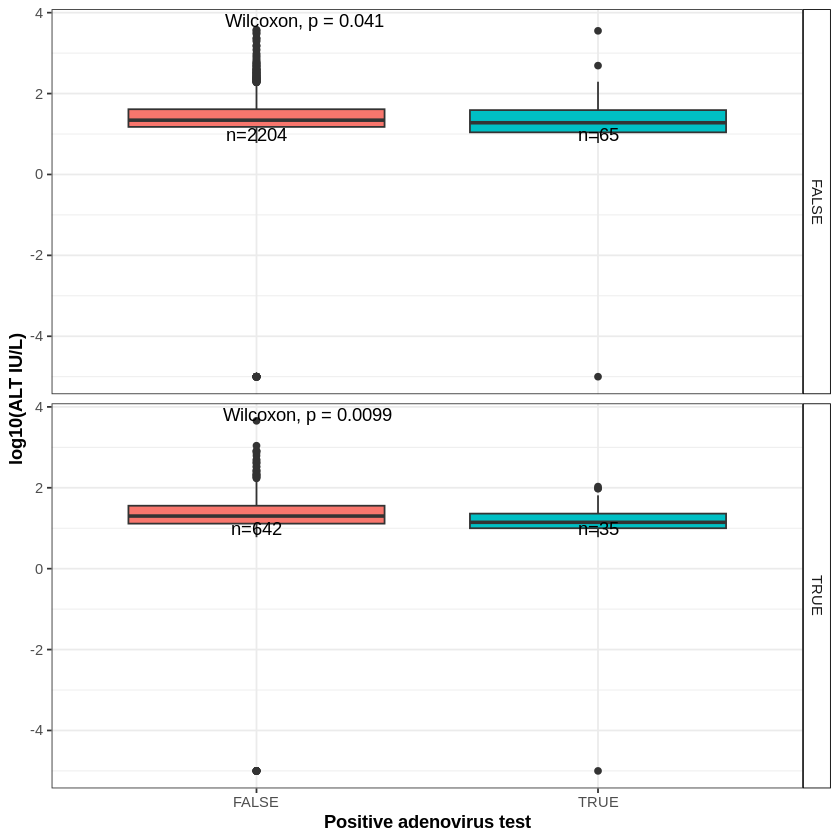

In [134]:
# Test for differences in ALT
count_df <- micro_alt %>%
    filter(!is.na(ALT_class)) %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    filter(!is.na(ALT_class)) %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/ALT_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = as.numeric(Value)`.
Caused by warning:
! NAs introduced by coercion”
Joining with `by = join_by(ClusterID, AttendanceStartDate)`
`summarise()` has grouped output by 'adeno_pos'. You can override using the `.groups` argument.



	Wilcoxon rank sum test

data:  log_value by adeno_pos
W = 14140, p-value = 0.009898
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test

data:  log_value by adeno_pos
W = 82273, p-value = 0.04085
alternative hypothesis: true location shift is not equal to 0


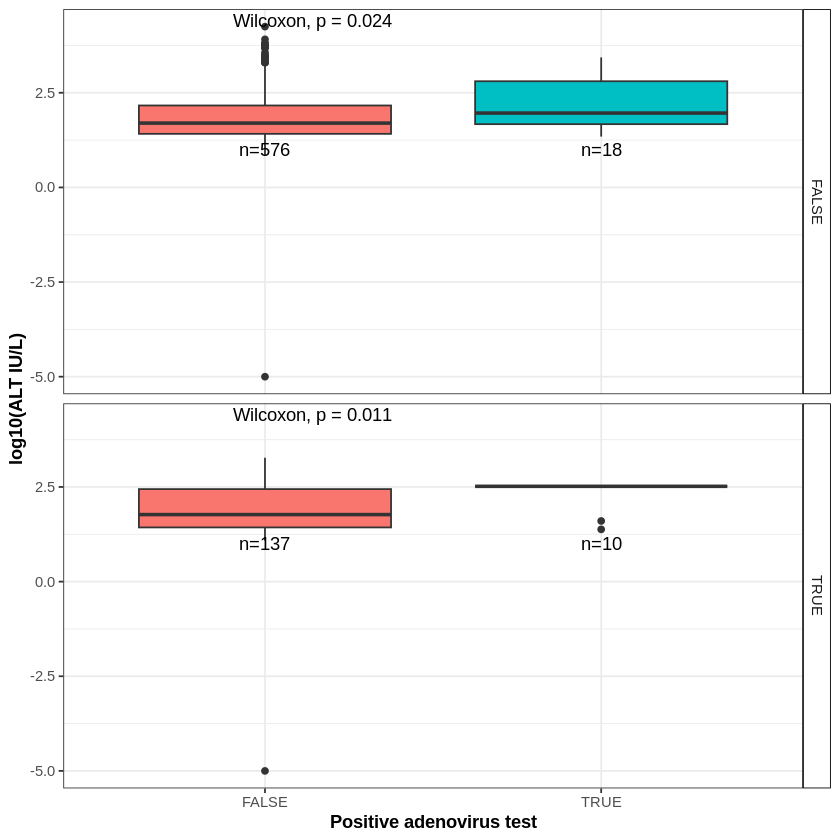

In [136]:
AST_tests <- test_df %>%
    filter(TestName == "AST") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value))

micro_ast <- micro_filt %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    inner_join(AST_tests) %>%
    mutate(log_value = log10(Value + 0.00001)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

# Test for differences in AST
count_df <- micro_ast %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_ast %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/AST_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

In [ ]:
compare_means(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), method = "wilcox.test")

In [ ]:
# Test for differences in ALT
count_df <- micro_alt %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/ALT_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

In [ ]:
ALT_tests <- test_df %>%
    filter(TestName == "ALT") %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    select(-CollectionDateTime, -ReceiveDateTime) %>%
    mutate(Value = as.numeric(Value)) %>%
    mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
    mutate(ALT_class = case_when(Value <= 45 ~ "Normal <= 45",
                                 Value > 45 & Value <= 90 ~ "Mild (46-90 IU/L)",
                                 Value > 90 & Value <= 500  ~ "Moderate (91-500 IU/L)",
                                 Value > 500 ~ "Severe (>500IU/L)")) %>%
    mutate(ALT_class = factor(ALT_class, c("Normal <= 45", 
                                           "Mild (46-90 IU/L)", 
                                           "Moderate (91-500 IU/L)",
                                           "Severe (>500IU/L)"))) 
micro_alt <- micro_df %>%
    distinct(ClusterID, AttendanceStartDate, BugName, .keep_all = T) %>%
    filter(BatTestCode %in% adeno_tests$BatTestCode) %>%
    mutate(adeno_pos = ifelse(grepl("adeno", BugName, ignore.case = T), T, F),
           is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    inner_join(ALT_tests) %>%
    mutate(log_value = log10(Value + 0.00001)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

micro_alt %>% 
    group_by(adeno_pos, ALT_class) %>%
    summarise(n = n())

compare_means(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), method = "wilcox.test")

# Test for differences in ALT
count_df <- micro_alt %>%
    group_by(adeno_pos, is_outbreak) %>%
    summarise(n = n())

micro_alt %>%
    ggplot(aes(x = adeno_pos, y = log_value, fill = adeno_pos)) +
    geom_boxplot() +
    facet_grid(rows = vars(is_outbreak)) +
    geom_text(data = count_df, aes(x = adeno_pos, y = 1, label = str_glue("n={n}"))) +
    theme_bw() +
    labs(x = "Positive adenovirus test", y = "log10(ALT IU/L)") +
    theme(legend.position = "none",
         axis.title = element_text(face = "bold"),
         strip.background = element_rect(color = "black", fill = "white")) +
    stat_compare_means(method = "wilcox.test")

wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(is_outbreak), correct = F)
wilcox.test(log_value ~ adeno_pos, data = micro_alt %>% filter(!is_outbreak), correct = F)

ggsave("results/ALT_by_adeno_positivity.pdf", dpi = 300, width = 5, height = 5)

### Any positive test

In [ ]:
# micro_all_alt <- micro_all %>% 
#     inner_join(ALT_tests) %>%
#     mutate(BugName = ifelse(grepl("Staphy", BugName, ignore.case = T), "Staphylococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Strep", BugName, ignore.case = T), "Streptococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Candida", BugName, ignore.case = T), "Candida", BugName)) %>%
#     mutate(BugName = ifelse(grepl("influenza a|influenza b|flu a|flu b", BugName, ignore.case = T), "Influenza", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Escherichia|E. coli", BugName, ignore.case = T), "Escherichia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Enterococcus", BugName, ignore.case = T), "Enterococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Klebsiella", BugName, ignore.case = T), "Klebsiella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Acinetobacter", BugName, ignore.case = T), "Acinetobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Bacillus", BugName, ignore.case = T), "Bacillus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("HAEMOPHILUS", BugName, ignore.case = T), "Haemophilus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Parvimonas", BugName, ignore.case = T), "Parvimonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Burkholderia", BugName, ignore.case = T), "Burkholderia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Micrococcus", BugName, ignore.case = T), "Micrococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Proteus", BugName, ignore.case = T), "Proteus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Lactococcus", BugName, ignore.case = T), "Lactococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Adenovirus", BugName, ignore.case = T), "Adenovirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Rothia", BugName, ignore.case = T), "Rothia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Salmonella", BugName, ignore.case = T), "Salmonella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Actinomyces", BugName, ignore.case = T), "Actinomyces", BugName)) %>%
#     mutate(BugName = ifelse(grepl("ANAEROCOCCUS", BugName, ignore.case = T), "Anaerococcus ", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Pseudomonas", BugName, ignore.case = T), "Pseudomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Corynebacterium", BugName, ignore.case = T), "Corynebacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Yersinia", BugName, ignore.case = T), "Yersinia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("ASPERGILLUS", BugName, ignore.case = T), "Aspergillus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("TURICELLA", BugName, ignore.case = T), "Turicella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("serratia", BugName, ignore.case = T), "Serratia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("moraxella", BugName, ignore.case = T), "Moraxella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("bacteroides", BugName, ignore.case = T), "Bacteroides", BugName)) %>%
#     mutate(BugName = ifelse(grepl("shigella", BugName, ignore.case = T), "Shigella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("enterobacter", BugName, ignore.case = T), "Enterobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("GORDONIA", BugName, ignore.case = T), "Gordonia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("rhinovirus", BugName, ignore.case = T), "Rhinovirus/Enterovirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("aerococcus", BugName, ignore.case = T), "Aerococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("aeromonas", BugName, ignore.case = T), "Aeromonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Raoultella", BugName, ignore.case = T), "Raoultella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Brevibacterium", BugName, ignore.case = T), "Brevibacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Prevotella", BugName, ignore.case = T), "Prevotella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Trichophyton", BugName, ignore.case = T), "Trichophyton", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Parainfluenzavirus|parainfluenza virus", BugName, ignore.case = T), "Parainfluenzavirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Clostridium", BugName, ignore.case = T), "Clostridium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Neisseria", BugName, ignore.case = T), "Neisseria", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Fusobacterium", BugName, ignore.case = T), "Fusobacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Atopobium", BugName, ignore.case = T), "Atopobium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Aggregatibacter", BugName, ignore.case = T), "Aggregatibacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Sphingobacterium", BugName, ignore.case = T), "Sphingobacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Bradyrhizobium", BugName, ignore.case = T), "Bradyrhizobium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Ruminococcus", BugName, ignore.case = T), "Ruminococcus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Alcaligenes", BugName, ignore.case = T), "Alcaligenes", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Paracoccus", BugName, ignore.case = T), "Paracoccus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("HAEMATOBACTER", BugName, ignore.case = T), "Haematobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Microbacterium", BugName, ignore.case = T), "Microbacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Coronavirus", BugName, ignore.case = T), "Coronavirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Mycobacterium", BugName, ignore.case = T), "Mycobacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Citrobacter", BugName, ignore.case = T), "Citrobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Propionibacterium", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Respiratory Syncytial Virus", BugName, ignore.case = T), "RSV", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Herpes", BugName, ignore.case = T), "Herpesvirus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("ACHROMOBACTER", BugName, ignore.case = T), "Achromobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Kocuria", BugName, ignore.case = T), "Kocuria", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Roseomonas", BugName, ignore.case = T), "Roseomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Morganella", BugName, ignore.case = T), "Morganella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Listeria", BugName, ignore.case = T), "Listeria", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Chlamydia", BugName, ignore.case = T), "Cutibacterium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Stenotrophomonas", BugName, ignore.case = T), "Stenotrophomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Sphingomonas", BugName, ignore.case = T), "Sphingomonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("VEILLONELLA", BugName, ignore.case = T), "Veillonella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Finegoldia", BugName, ignore.case = T), "Finegoldia", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Pasteurella", BugName, ignore.case = T), "Pasteurella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Campylobacter", BugName, ignore.case = T), "Campylobacter", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Rhizobium", BugName, ignore.case = T), "Rhizobium", BugName)) %>%
#     mutate(BugName = ifelse(grepl("PEPTONIPHILUS", BugName, ignore.case = T), "Peptoniphilus", BugName)) %>%
#     mutate(BugName = ifelse(grepl("Brevundimonas", BugName, ignore.case = T), "Brevundimonas", BugName)) %>%
#     mutate(BugName = ifelse(grepl("GEMELLA", BugName, ignore.case = T), "Gemella", BugName)) %>%
#     mutate(BugName = ifelse(grepl("cocci|colonies|aerobic|anaerobic|anaerobes|gram positive|gram negative|Fungal", BugName, ignore.case = T), "ambiguous", BugName))


In [ ]:
    test_temp <- micro_all_alt %>%
        filter(BugName == bug) %>%
        distinct(BatTestName)
    
    # Get proportions of bug-positive patients per ALT class
    micro_all_alt %>%
        filter(BatTestName %in% test_temp$BatTestName) %>%
        mutate(positive = ifelse(BugName == bug, T, F))
        group_by(ALT_class) %>%
        summarise(n = n()) %>%
        mutate(prop = n / sum(n))

In [ ]:
micro_all_alt <- micro_all_df %>%
    mutate(is_outbreak = ifelse(AttendanceStartDate <= as.Date("2022-08-31") & AttendanceStartDate >= as.Date("2021-10-01"),
                                T, F)) %>%
    inner_join(ALT_tests) %>%
    mutate(log_value = log10(Value + 0.00001)) %>%
    filter(AttendanceMonth < as.Date("2023-01-01"))

# Get top 
bug_morsels <- foreach(bug = unique(micro_all_alt$BugName)) %do% {
    test_temp <- micro_all_alt %>%
        filter(BugName == bug) %>%
        distinct(BatTestName)
    
    # Get proportions of bug-positive patients per ALT class
    micro_all_alt %>%
        filter(BatTestName %in% test_temp$BatTestName) %>%
        mutate(positive = ifelse(BugName == bug, T, F))
        group_by(ALT_class) %>%
        summarise(n = n()) %>%
        mutate(prop = n / sum(n))
    
    micro_all_alt %>%
    group_by(BugName, ALT_class) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    head(5)
}



# micro_alt <- micro_filt %>%
#     left_join(test_df %>% select(-CollectionDateTime, -ReceiveDateTime)) %>%
#     filter(TestName == "ALT") %>%
#     mutate(Value = as.numeric(Value)) %>%
#     mutate(Value = ifelse(is.na(Value), 0, Value)) %>%
#     mutate(ALT_class = case_when(Value <= 45 ~ "Normal <= 45",
#                                  Value > 45 & Value <= 90 ~ "Mild (46-90 IU/L)",
#                                  Value > 90 & Value <= 500  ~ "Moderate (91-500 IU/L)",
#                                  Value > 500 ~ "Severe (>500IU/L)")) %>%
#     mutate(ALT_class = factor(ALT_class, c("Normal <= 45", 
#                                            "Mild (46-90 IU/L)", 
#                                            "Moderate (91-500 IU/L)",
#                                            "Severe (>500IU/L)"))) 
# micro_alt
#     group_by(AttendanceMonth, age_group, adeno_pos) %>%
#     summarise(median_ALT = median(Value)) %>%
#     ggplot(aes(x = AttendanceMonth, y = median_ALT, color = adeno_pos)) +
#     facet_grid(rows = "age_group") +
#     geom_point() +
#     geom_line()

In [ ]:
dawdawdwdadwwddwwdadawd

In [ ]:
ALT_df <- test_df %>%
    left_join(age_df %>% select(ClusterID, AttendanceStartDate, LinkedSex)) %>%
    filter(TestName == "ALT") %>%
    mutate(Value = as.numeric(Value)) %>%
    # Replace <6, <30 with 0.0001 to prevent divide by zero error
    mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
    # Define ULN values
    mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
    # Get fold difference
    mutate(ALT_fold = Value / ULN) %>%
    mutate(ALT_class = case_when(ALT_fold <= 1 ~ "<=1x ULN",
                                 ALT_fold > 1 & ALT_fold <= 2 ~ "1-2x ULN",
                                 ALT_fold >= 2 & ALT_fold <= 5 ~ "2-5x ULN",
                                 ALT_fold >= 5 & Value <= 500 ~ "5x ULN-500IU/L",
                                 Value > 500 ~ ">500IU/L"))

head(ALT_df)

In [ ]:
parsed_micro %>%
    left_join(ALT_df %>% select(ClusterID, AttendanceStartDate, TestName, Value)) %>%
#     filter(TestName == "ALT") %>%
    mutate(Value = as.numeric(Value)) %>%
    filter(!is.na(Value)) %>%
    group_by(AttendanceTwoMonth, adeno_pos, age_group) %>%
    summarise(median_ALT = median(Value)) %>%
    ggplot(aes(x = AttendanceTwoMonth, y = median_ALT, color = adeno_pos)) +
        geom_line() +
        geom_point() +
        facet_grid(rows = "age_group", scales = "free") +
        annotate("rect",
                 xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
                 ymin = -Inf, ymax = Inf,
                 fill = "grey83",
                 alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
        labs(x = "Two-month intervals", y = "No. of patients")
    

In [ ]:
parsed_micro %>%
    inner_join(ALT_df %>% select(ClusterID, AttendanceStartDate, TestName, Value, ALT_class)) %>%
    group_by(ALT_class, AttendanceMonth, age_group) %>%
    summarise(prop_pos = sum(adeno_pos) / n()) %>%
    ggplot(aes(x = AttendanceMonth, y = prop_pos, color = age_group)) +
    geom_line() +
    geom_point() +
    facet_grid(rows = "ALT_class", scales = "free") +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
    theme_bw() +
    labs(x = "Two-month intervals", y = "Prop. of adenovirus positive tests")

In [ ]:
micro_df <- fread("data/IORD_ASHep-UE_34_20230120_Microbiology.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate))

age_df <- fread("data/IORD_ASHep-UE_34_20230120_Attendances.csv") %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate),
           AttendanceEndDate = as.Date(AttendanceEndDate),
           LinkedBirthmonth = as.Date(LinkedBirthmonth)) %>%
    mutate(age_upon_presentation = time_length(AttendanceStartDate -
                                               LinkedBirthmonth, "year")) %>%
    arrange(AttendanceStartDate)

### Microbiology tests per month

In [ ]:
micro_df %>%

diag_plot_df %>%
    ggplot(aes(x = AttendanceMonth, y = n, color = DiagCode)) +
        geom_line() +
        geom_point() +
        facet_wrap(~ DiagCode, ncol = 3, scales = "free") +
        annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
#         scale_color_manual(values = pal) +
        labs(x = "Two-month intervals", y = "Frequency") +
        theme(legend.position = "none")

### ALT per diagnostic code per month

In [ ]:
micro_df

In [ ]:
ALT_class_df <- month_df %>% 
    select(ClusterID, AttendanceStartDate, CollectionMonth, TestName, LinkedSex, Value) %>%
    filter(TestName == "ALT",
           LinkedSex %in% c("M", "F")) %>%
    mutate(AttendanceStartDate = as.Date(AttendanceStartDate)) %>%
    left_join(age_df %>% select(ClusterID, AttendanceStartDate, age_upon_presentation)) %>%
    arrange(AttendanceStartDate) %>%
#     distinct(ClusterID, .keep_all = T) %>%
    mutate(age_upon_presentation = floor(age_upon_presentation)) %>% 
    mutate(age_group = case_when(age_upon_presentation < 7 ~ "<7",
                                 age_upon_presentation >= 6 & age_upon_presentation <= 15 ~ "7-15",
                                 age_upon_presentation >= 16 ~ ">15"),
           Value = as.numeric(Value)) %>%
    # Replace <6, <30 with 0.0001 to prevent divide by zero error
    mutate(Value = ifelse(is.na(Value), 0.0001, Value)) %>%
    # Define ULN values
    mutate(ULN = ifelse(LinkedSex == "M", 50, 30)) %>%
    # Get fold difference
    mutate(ALT_fold = Value / ULN) %>%
    mutate(ALT_class = case_when(ALT_fold <= 1 ~ "<=1x ULN",
                                 ALT_fold > 1 & ALT_fold <= 2 ~ "1-2x ULN",
                                 ALT_fold >= 2 & ALT_fold <= 5 ~ "2-5x ULN",
                                 ALT_fold >= 5 & Value <= 500 ~ "5x ULN-500IU/L",
                                 Value > 500 ~ ">500IU/L")) %>%
    left_join(diag_df %>% select(ClusterID, AttendanceStartDate, DiagCode)) %>%
    distinct(ClusterID, DiagCode, AttendanceStartDate, .keep_all = T) %>%
    mutate(CollectionMonth = as.Date(CollectionMonth))


In [ ]:
# only_NA <- ALT_class_df %>%
#     arrange(DiagCode) %>%
#     distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
#     filter(ALT_class != "<=1x ULN",
#            is.na(DiagCode),
#            CollectionMonth < as.Date("2023-01-01")) %>%
#     distinct(ClusterID)

# ALT_class_df %>%
# #     filter(ClusterID %in% only_NA$ClusterID) %>%
# #     group_by(ClusterID, AttendanceStartDate) %>%
# #     summarise(n = n_distinct(DiagCode)) %>%
# #     arrange(desc(n))
#     filter(ClusterID == 372998)

# ALT_class_df %>%
#     filter(ClusterID %in% only_NA$ClusterID) %>%
#     group_by(ClusterID, AttendanceStartDate) %>%
#     summarise(n = n_distinct(DiagCode)) %>%
#     arrange(desc(n))


In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN",
           is.na(DiagCode),
           CollectionMonth < as.Date("2023-01-01")) %>%
    group_by(CollectionMonth) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = CollectionMonth, y = n)) +
#     facet_grid(rows = "age_group", scales = "free") +
    geom_line(color = "blue") +
    geom_point(color = "blue") +
    geom_ma(n = 12, 
            color = "red", 
            lty = 2) +
            annotate("rect",
             xmin = as.Date(-Inf), xmax = as.Date("2020-03-01"), 
             ymin = -Inf, ymax = Inf,
             fill = "grey83",
             alpha = 0.3) +
        annotate("rect",
                 xmin = as.Date("2020-03-01"), xmax = as.Date(Inf), 
                 ymin = -Inf, ymax = Inf,
                 fill = "lightgoldenrod1",
                 alpha = 0.3) +
        annotate("rect",
             xmin = as.Date("2021-10-01"), xmax = as.Date("2022-06-01"), 
             ymin = -Inf, ymax = Inf,
             fill = NA,
             color = "black",
             lty = "dashed",
             alpha = 0.3) +
        theme_bw() +
#         scale_color_manual(values = pal) +
        labs(x = "Two-month intervals", y = "No. of patients") +
        theme(legend.position = "none")
    

In [ ]:
ALT_class_df %>%
    arrange(DiagCode) %>%
    distinct(ClusterID, AttendanceStartDate, .keep_all = T) %>%
    filter(ALT_class != "<=1x ULN") %>%
    filter(!(DiagCode %in% c("B162", "B178", "K752", "B189", "B180", "B188"))) %>%
    arrange(ClusterID) %>%
    group_by(CollectionMonth, DiagCode) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = CollectionMonth, y = n, color = DiagCode)) +
    facet_wrap(~DiagCode, scale = "free") +
    geom_point() +
    geom_line()